In [1]:
import numpy as np
import pandas as pd

In [2]:
files = []
for i in range(29):
    tempdf = pd.read_csv(f'data/User{i+1}.csv', delimiter = ',')
    tempdf['User'] = i
    files.append(tempdf)
df = pd.concat(files, ignore_index = True)

In [3]:
df.dtypes

Game Completed Date            object
Team                           object
Outcome                        object
Task Completed                 object
All Tasks Completed            object
Murdered                       object
Imposter Kills                 object
Game Length                    object
Ejected                        object
Sabotages Fixed               float64
Time to complete all tasks     object
Rank Change                    object
Region/Game Code               object
User                            int64
dtype: object

In [4]:
df[['Task Completed', 'Imposter Kills']] = df[['Task Completed', 'Imposter Kills']].apply(pd.to_numeric, errors = 'coerce')

In [5]:
df['Region'] = df['Region/Game Code'].str.extract(r'^(.*?)/')
df['Region'].value_counts()


NA         1436
Europe      791
Name: Region, dtype: int64

In [6]:
df['Game Length'] = df['Game Length'].apply(pd.to_timedelta)
df['Game Length'] = df['Game Length'] / np.timedelta64(1, 's')

In [7]:
df['Time to complete all tasks'] = df['Time to complete all tasks'].apply(pd.to_timedelta, errors = 'coerce')
df['Time to complete all tasks'] = df['Time to complete all tasks'] / np.timedelta64(1, 's')

In [8]:
crewmate = df[['Team',
               'Outcome',
               'Task Completed',
               'All Tasks Completed',
               'Murdered',
               'Game Length',
               'Ejected',
              'Sabotages Fixed',
              'Region',
              'User']][df['Team'] == 'Crewmate']
crewmate.head()

,Team,Outcome,Task Completed,All Tasks Completed,Murdered,Game Length,Ejected,Sabotages Fixed,Region,User
0,Crewmate,Win,3.0,No,Yes,424.0,No,2.0,NA,0
1,Crewmate,Loss,7.0,Yes,No,981.0,No,1.0,NA,0
2,Crewmate,Win,3.0,No,No,693.0,No,0.0,NA,0
4,Crewmate,Loss,4.0,No,No,310.0,No,0.0,Europe,0
5,Crewmate,Loss,7.0,Yes,Yes,982.0,No,0.0,Europe,0


In [9]:
crewmate['Outcome'] = crewmate['Outcome'].replace(['Loss', 'Win'],[0, 1])
crewmate['All Tasks Completed'] = crewmate['All Tasks Completed'].replace(['No', 'Yes'],[0, 1])
crewmate['Murdered'] = crewmate['Murdered'].replace(['No', 'Yes'],[0, 1])
crewmate['Ejected'] = crewmate['Ejected'].replace(['No', 'Yes'],[0, 1])
crewmate['Region'] = crewmate['Region'].replace(['NA ', 'Europe '],[0, 1])
crewmate.head()

,Team,Outcome,Task Completed,All Tasks Completed,Murdered,Game Length,Ejected,Sabotages Fixed,Region,User
0,Crewmate,1,3.0,0,1,424.0,0,2.0,0,0
1,Crewmate,0,7.0,1,0,981.0,0,1.0,0,0
2,Crewmate,1,3.0,0,0,693.0,0,0.0,0,0
4,Crewmate,0,4.0,0,0,310.0,0,0.0,1,0
5,Crewmate,0,7.0,1,1,982.0,0,0.0,1,0


In [10]:
target = crewmate['Outcome']
crewmate = crewmate.drop(['Outcome','Team'], axis =1)
crewmate.head()

,Task Completed,All Tasks Completed,Murdered,Game Length,Ejected,Sabotages Fixed,Region,User
0,3.0,0,1,424.0,0,2.0,0,0
1,7.0,1,0,981.0,0,1.0,0,0
2,3.0,0,0,693.0,0,0.0,0,0
4,4.0,0,0,310.0,0,0.0,1,0
5,7.0,1,1,982.0,0,0.0,1,0


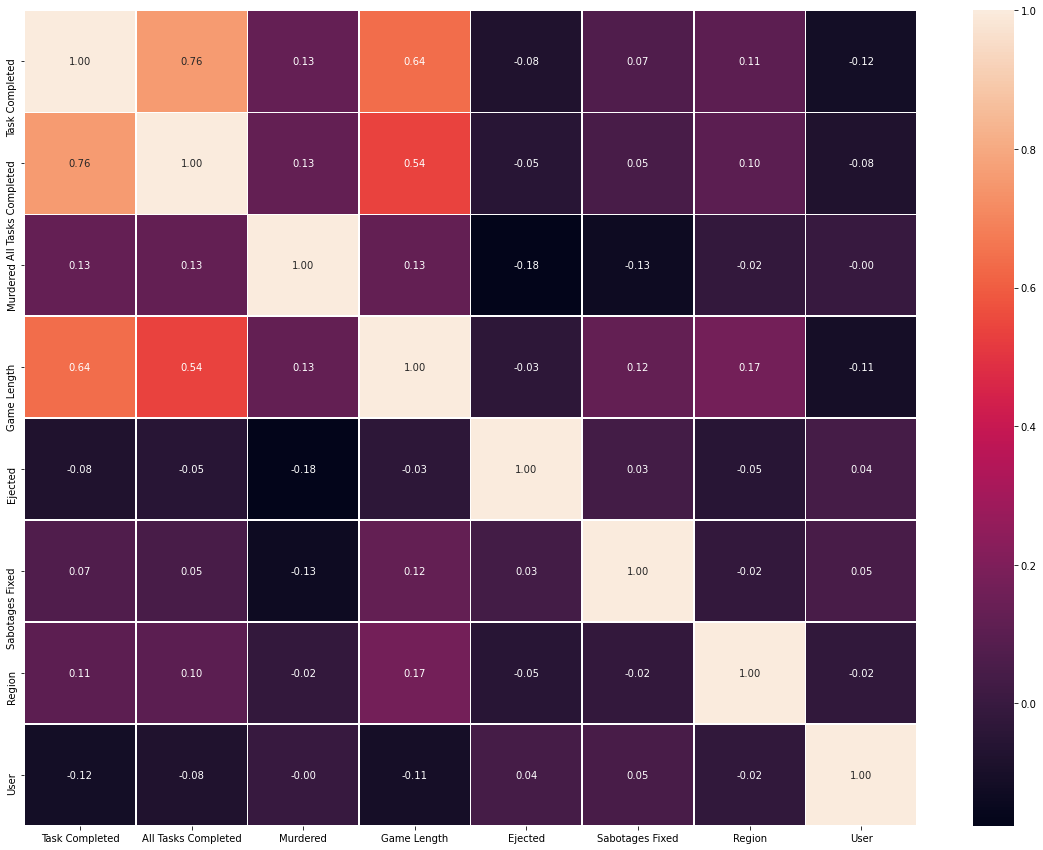

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
corrlation_matrix = crewmate.corr()
fig, ax = plt.subplots(figsize = (20, 15))
ax = sns.heatmap(corrlation_matrix,
                annot = True,
                linewidths = 0.5,
                fmt = ".2f")

In [ ]:
def user_train_valid_split(users_i,valid_ratio,possible=False):
    n = sum(users_i)
    target = int(np.floor(valid_ratio*n))
    while not possible:
        possible, validation_indices = user_split(users_i,target)
        target -= 1
    training_indices = [i for i in range(len(users_i)) if i not in validation_indices]
    return training_indices, validation_indices

def user_split(users_i,target):  
    # Reference: https://levelup.gitconnected.com/dynamic-programming-subset-sum-c386126621cd
    n = len(users_i)
    solution = [[False for j in range(int(target+1))] for i in range(n+1)]
    # base cases
    for i in range(n):
        solution[i][0] = True
    # other cases
    for i in range(1,n+1):
        for j in range(1,target+1):
            solution[i][j] = solution[i-1][j]
            if(solution[i][j] == False and j >= users_i[i-1]):
                solution[i][j] = solution[i][j] or solution[i-1][j-users_i[i-1]]
    # check if the subset sum is possible
    possible = solution[len(users_i)][target]
    subset = []
    if not possible: return possible, subset
    # return the subset solution if one exists
    y = len(users_i)
    x = target
    while x != 0:
        if solution[y-1][x] == False:
            subset.append(y-1)
            x -= users_i[y-1]
        else: 
            y -= 1
    return possible, subset

In [ ]:
crewmates_i = list(crewmate["User"].value_counts(sort = False))
test_ratio = .25
training_indices, test_indices = user_train_valid_split(crewmates_i,test_ratio)

#check
train_sum = sum([crewmates_i[i] for i in training_indices])
test_sum = sum([crewmates_i[i] for i in test_indices])
print("expected valid ratio: {}, actual: {}".format(test_ratio, test_sum/(train_sum+test_sum)))

train_data = crewmate.loc[crewmate['User'].isin(training_indices)]
test_data = crewmate.loc[crewmate['User'].isin(test_indices)]
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

In [ ]:
train_data

In [ ]:
test_data